In [1]:
# note that running this notebook requires installing oncophylo 
#   pip install oncophylo
import os, sys
import anndata

import oncophylo as op 
import numpy as np
import pandas as pd

# loading tree from json
import json 
import networkx as nx

Error importing in API mode: ImportError("dlopen(/Users/ethank/LoPhy/env/lib/python3.13/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <B96A8100-FA7A-3EFC-8726-931D26646DE6> /Users/ethank/LoPhy/env/lib/python3.13/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.


In [2]:
# mean absolute error
def mae(A1, A2):
    d1,d2 = A1.shape
    return (1.0/(d1*d2))*np.sum(np.abs(A1-A2))

# load tree from adata
def load_tree(adata, name):
    return nx.node_link_graph(json.loads(adata.uns[name]), edges="links")

In [3]:
# output path 
output_path = os.path.join(os.getcwd(), "example", "outputs")

In [4]:
# read in AnnData generated from simulator
adata = anndata.read_h5ad(os.path.join(os.getcwd(), "example", "h5ad", "adata.h5ad"))

In [5]:
# obtain necessary data from adata
cells = adata.obs.index
mutations = adata.var.index
character_matrix = pd.DataFrame(adata.X, index=cells, columns=mutations)
variant_reads_df = pd.DataFrame(adata.layers[op.ul.DATA.VARIANT_READS_CORRUPT], index=cells, columns=mutations)
total_reads_df = pd.DataFrame(adata.layers[op.ul.DATA.TOTAL_READS_CORRUPT], index=cells, columns=mutations)
regions_df = adata.uns[op.ul.DATA.REGION_READS]
regions_df.columns = regions_df.columns.astype(int)
meta_df = adata.var.set_index("CHR").drop(columns="VARIANT_TYPE")
cell_samples = adata.obs[op.ul.DATA.CELL_SAMPLE]

In [6]:
# run LoPhy
solution = op.tl.solver.LoPhy(character_matrix, 
                              variant_reads_df, 
                              total_reads_df,                        
                              regions_df, 
                              meta_df,
                              cell_samples=cell_samples,
                              fn=0.05,
                              fp=0.02,
                              remove_temp_dir=False,
                              hom_precision=15.0,
                              het_precision=4.0,
                              destination_dir=output_path,
                              seed=0) # seed allow reproducibility


In [7]:
# obtain true cluster assignment and mutant/total copy number profiles
true_cluster_assignments = adata.obs.cluster_id
cells_true_mutant_cns = pd.DataFrame(adata.uns[op.ul.DATA.MUTANT_COPY_NUMBERS][adata.obs[op.ul.DATA.CLUSTER_ID]], index=cells)
cells_true_total_cns = pd.DataFrame(adata.uns[op.ul.DATA.TOTAL_COPY_NUMBERS][:,adata.obs[op.ul.DATA.CLUSTER_ID]].T, index=cells)

In [9]:
# grab data from LoPhy solution
T = solution[op.ul.DATA.CELL_TREE]
sigma = np.array(T.graph["cell_assignments"], dtype=int)
clone_mutant_cns = np.array(T.graph[op.ul.DATA.MUTANT_COPY_NUMBERS], dtype=int)
clone_total_cns = np.array(T.graph[op.ul.DATA.TOTAL_COPY_NUMBERS], dtype=int)
cells_predicted_mutant_cns = pd.DataFrame(clone_mutant_cns[sigma], index=cells)
cells_predicted_total_cns = pd.DataFrame(clone_total_cns[sigma], index=cells)

In [10]:
print(f"MCN-MAE: {mae(cells_true_mutant_cns.values, cells_predicted_mutant_cns.values)}")

MCN-MAE: 0.001575


In [11]:
print(f"TCN-MAE: {mae(cells_true_total_cns.values, cells_predicted_total_cns.values)}")

TCN-MAE: 0.0


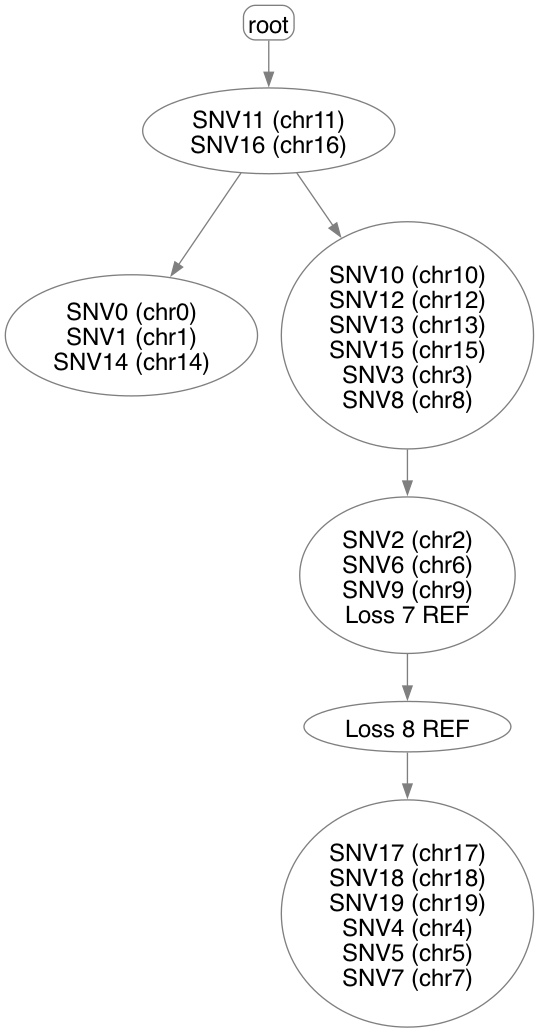

In [16]:
# plot LoPhy's tree
op.pl.show_tree(T)

In [20]:
# grab ground truth tree from AnnData
T_true = load_tree(adata, op.ul.DATA.MUTATION_TREE)

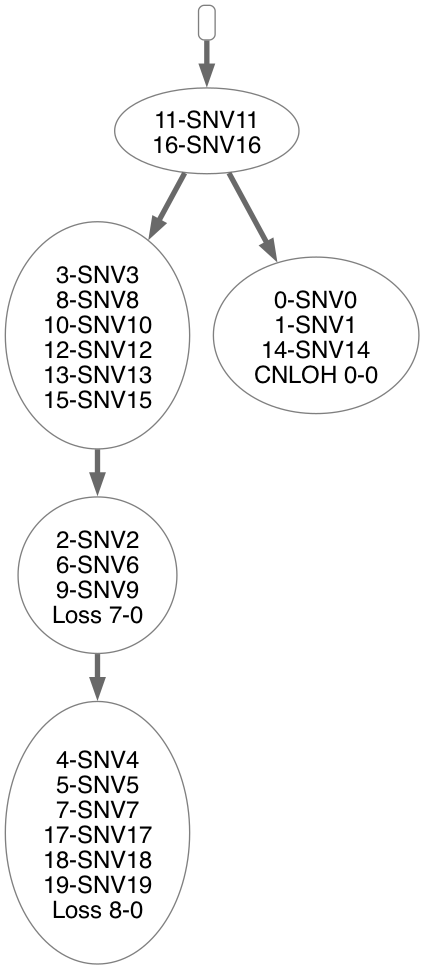

In [21]:
# plot ground truth tree
op.pl.show_tree(T_true)